In [1]:
import pynini as pn

In [2]:
PHONE_TABLE = """
sil spn 
a aj aw 
o ow
ə ɥ 
e ej  
i io
j w u y
p pʰ m f
t tʰ n l
k kʰ x 
tɕ tɕʰ  
ʈʂ ʈʂʰ ʂ ʐ ʐ̩
ts tsʰ ɕ
z z̩ s 
ŋ ŋ̍ ɻ ʔ
"""

In [3]:
## Confusingly, the ilabel for fst is 1-based, but log-like matrix is 0-based
## The code in Kaldi (decodable-matrix.h:240) will offset the ilabel by 1 for us.
phone_list = PHONE_TABLE.strip().replace("\n", " ").split()
phone2id = {x: i+1 for i, x in enumerate(phone_list)}
phone2id

{'sil': 1,
 'spn': 2,
 'a': 3,
 'aj': 4,
 'aw': 5,
 'o': 6,
 'ow': 7,
 'ə': 8,
 'ɥ': 9,
 'e': 10,
 'ej': 11,
 'i': 12,
 'io': 13,
 'j': 14,
 'w': 15,
 'u': 16,
 'y': 17,
 'p': 18,
 'pʰ': 19,
 'm': 20,
 'f': 21,
 't': 22,
 'tʰ': 23,
 'n': 24,
 'l': 25,
 'k': 26,
 'kʰ': 27,
 'x': 28,
 'tɕ': 29,
 'tɕʰ': 30,
 'ʈʂ': 31,
 'ʈʂʰ': 32,
 'ʂ': 33,
 'ʐ': 34,
 'ʐ̩': 35,
 'ts': 36,
 'tsʰ': 37,
 'ɕ': 38,
 'z': 39,
 'z̩': 40,
 's': 41,
 'ŋ': 42,
 'ŋ̍': 43,
 'ɻ': 44,
 'ʔ': 45}

In [4]:
import re
phone_seq = "ɕ j e˥˩ n ts aj˥˩".split()
phone_seq = [re.sub("[\u02e5-\u02e9]+", "", x) for x in phone_seq]

In [5]:
st = pn.SymbolTable()
st.add_symbol("<eps>", 0)
for phone_i, phone_x in enumerate(phone_seq):
    st.add_symbol(phone_x, phone2id[phone_x])

In [6]:
list(st)

[(0, '<eps>'),
 (38, 'ɕ'),
 (14, 'j'),
 (10, 'e'),
 (24, 'n'),
 (36, 'ts'),
 (4, 'aj')]

In [7]:
fst = pn.accep(" ".join(phone_seq), token_type=st)
fst.set_input_symbols(st)
fst_states = list(fst.states())
emit_table = {state_i: phone2id[phone_x] for state_i, phone_x in enumerate(phone_seq)}

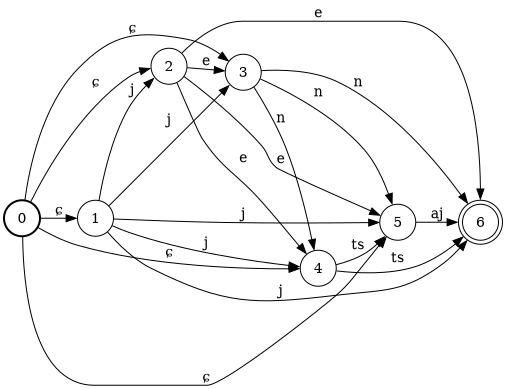

In [8]:
## Add skip arcs

for skip_dist in range(2, len(fst_states)-1):
    for state_i in range(len(fst_states) - skip_dist):
        emit_symint = emit_table[state_i]
        fst.add_arc(state_i, pn.Arc(emit_symint, emit_symint, 
                                    weight=None, nextstate=state_i + skip_dist))
fst        

In [9]:
paths = fst.paths(output_token_type=st)

In [10]:
pn.Weight.one("tropical") == fst.final(6)

True

In [11]:
## Add self loop
for state_i in fst.states():    
    if fst.final(state_i) == pn.Weight.one("tropical"):
        continue
    emit_symint = emit_table[state_i]
    fst.add_arc(state_i, 
        pn.Arc(emit_symint, emit_symint,
               weight=None, 
               nextstate=state_i))

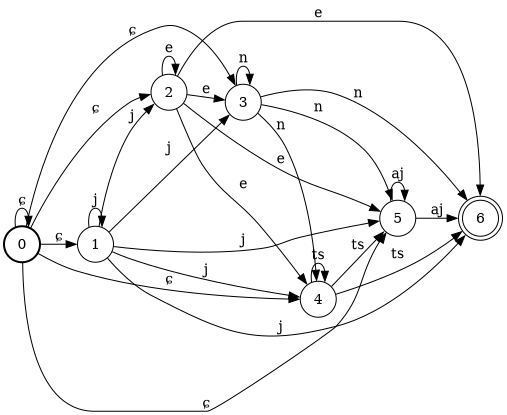

In [12]:
fst

In [13]:
fst.set_input_symbols(None)
fst.write("../../data/fst/xianzai.fst")